Ionbot identifications of different ionbot versions are compared to see whether this contributes to bias

In [8]:
import pandas as pd
from collections import defaultdict
import mysql.connector
import glob
import os
import csv
import numpy as np
import json
from master_functions import dbf
pd.set_option('display.max_columns', 65)
db_f = dbf()

connection succesfull


In [9]:
def find_pxd_path(pxds: list, return_path = False):
        '''Given a list of pxds, this function searches the compomics directories for the pxd directory and returns the pxds it finds
        
        If return path is set to True, returns (x,y,z)
        
        - x = list of pxd that were found
        - y = dictionary of path: amount of files
        - z = ionbot version paths'''
        
        path_found = []
        version_path = []
        file_output = {}
        pxd_found = []
        for pxd in pxds:
            for path in glob.glob("/home/compomics/mounts/*/*/PRIDE_DATA/" + str(pxd)):
                
                pxd_found.append(pxd)
                path_found.append(path)
        
        flag = False
        for path in path_found:
            count = 0
            for version in glob.glob(path + '/IONBOT_v*/*'):
                if count == 0:
                    version_path.append("/".join(version.split('/')[0:-1]))
                count += 1
            
            file_output[path] = count

        print(f"Found {len(pxd_found)} out of {len(pxds)}.")
        if not return_path:
            return pxd_found
        return pxd_found, file_output, version_path

In [10]:
# Get all pxd paths with ionbot version maps and metadata
pxd_dir = glob.glob("/home/compomics/mounts/*/*/PRIDE_DATA/*/*")
meta = pd.read_csv("../Metadata/unified_metadata.csv")

In [11]:
# Filter relevant pxds (those used in the thesis)
relevenat_pxd_dir = [x for x in pxd_dir if x.split("/")[7] in meta.PXD_accession.unique()]

In [12]:
# Only get paths for relevant ionbot versions
pxds = {}
ionbot_versions = ['IONBOT_v0.6.0',
 'IONBOT_v0.6.2',
 'IONBOT_v0.6.3',
 'IONBOT_v0.7.0',
 'IONBOT_v0.8.0',
 'IONBOT_v0.9.0',]

for path in relevenat_pxd_dir:
    path_split = path.split("/")

    if path_split[-1] in ionbot_versions:
        if path_split[-2] not in list(pxds.keys()):
            pxds[path_split[-2]] = [path]
        else:
            pxds[path_split[-2]].append(path)
pxds = {pxd: versions for pxd,versions in pxds.items() if len(versions)>1}

In [9]:
# 29 projects have multiple ionbot version output files
len(pxds)

29

In [10]:
glob.glob('/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD001327/IONBOT_v0.8.0/*/*')[:3]

['/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD001327/IONBOT_v0.8.0/ZR_con_1d_130618_cyt2b.mgf.gzip/ZR_con_1d_130618_cyt2b.mgf.gzip.ionbot.csv',
 '/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD001327/IONBOT_v0.8.0/ZR_con_1d_130618_cyt2b.mgf.gzip/ionbot.stats.csv',
 '/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD001327/IONBOT_v0.8.0/ZR_con_1d_130618_cyt2b.mgf.gzip/ionbot.meta.csv']

In [11]:
glob.glob('/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD003407/IONBOT_v0.6.2/*')[:3]

['/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD003407/IONBOT_v0.6.2/HUVEC_cyt_stim_5a_3.mgf.ionbot.meta.csv',
 '/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD003407/IONBOT_v0.6.2/HUVEC_cyt_stim_5b_3.mgf.ionbot.csv',
 '/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD003407/IONBOT_v0.6.2/HUVEC_cyt_stim_3b.mgf.ionbot.stats.csv']

In [14]:
def find_common_files(pxd_versions):
    path_found = []

    raw_file_paths = {}
    version_path = []
    file_output = {}

    for pxd_version in pxd_versions:
        for path in glob.glob("/home/compomics/mounts/*/*/PRIDE_DATA/" + pxd_version):
            path_found.append(path)
    
    return path_found
   

In [15]:
# project: filepaths
# project: filename: paths for multiple versions

# For ionbot versions 6 and  6.2: one folder below ionbot_v...
# For ionbot versions 7 and 8: two folders below ionbot_v...

def find_common_files2(paths):
    
    raw_file_paths = {}
    
    for project, path_list in paths.items():
        for path in path_list:
            for version in glob.glob(path+'/*'):
                
                project = version.split("/")[7]
                raw_name = version.split("/")[-1]
                
                if raw_name[-10:] != 'ionbot.csv':
                    for version2 in glob.glob(version+"/*"):
                        raw_name2 = version2.split("/")[-1]
                        
                        if raw_name2[-10:] == 'ionbot.csv':
                            if project not in raw_file_paths.keys():
                                raw_file_paths[project] = [version2]
                            else:
                                raw_file_paths[project].append(version2)
                
                else:
                    if project not in raw_file_paths.keys():
                        raw_file_paths[project] = [version]
                    else:
                        raw_file_paths[project].append(version)

    return raw_file_paths

In [16]:
paths_mv = find_common_files2(pxds)

In [17]:
project_filename_filepaths = {}
for project, file_paths in paths_mv.items():
    filenames = {}
    for file_path in file_paths:
        filename = file_path.split('/')[-1].split(".")[0]
        if filename not in filenames.keys():
            filenames[filename] = [file_path]
        else:
            filenames[filename].append(file_path)
    
    filenames = {filename: file_paths for filename,file_paths in filenames.items() if len(file_paths)>1}
    project_filename_filepaths[project] = filenames
    project_filename_filepaths = {project:rest for project,rest in project_filename_filepaths.items() if rest!={}}


In [17]:
len(project_filename_filepaths)

26

In [18]:
file_counts = 0
for x in project_filename_filepaths.values():
    file_counts+=len(x.keys())
print(file_counts)

1205


In [20]:
meta = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Metadata/unified_metadata.csv")

In [21]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [22]:
pepsql = "SELECT peptide_id, peptide_sequence FROM peptide"
pepData = pd.read_sql_query(pepsql, conn)

protsql = "SELECT peptide_id, uniprot_id FROM peptide_to_protein"
protData = pd.read_sql_query(protsql, conn)

pep_protData = pd.merge(protData, pepData, on = "peptide_id")

seqsql = "SELECT * FROM protein WHERE length IS NOT NULL"
seqData = pd.read_sql_query(seqsql, conn)
seqData["length"] = pd.to_numeric(seqData['length'], errors = "coerce")

pep_protData = pd.merge(pep_protData, seqData, on = "uniprot_id")

proteotypicData = pep_protData.loc[:,"peptide_id uniprot_id".split()].groupby("peptide_id").filter(lambda x: len(x) == 1)

# Check for protein identifiers that do not match the uniprot id regex.
proteotypicData = proteotypicData.copy()
contaminants = proteotypicData[proteotypicData.uniprot_id.str.contains(pat = r"[-_|]")].uniprot_id.unique().tolist()
print(contaminants[:5])

# From the cRAP https://www.thegpm.org/crap/index.html database, common contaminant identifiers were extracted
CRAP = pd.read_csv("CRAP.tsv", sep="\t")
CRAP["uniprot_id"] = CRAP.Description.apply(lambda x: x[1:7])

# All the failed uniprot ids are CRAP so delete them from the proteotypicData data structure

uniprot_parser_failed = {"AMYS_HUMAN|":     "/",        # Not found in uniprot
                         "ANT3_HUMAN|":     "P01008",   # Antithrombin-III
                         "B2MG_HUMAN|":     "P61769",   # Beta-2-microglobulin
                         "BID_HUMAN|":      "P55957",   # BH3-interacting domain death agonist
                         "CATG_HUMAN|":     "P08311",   # Cathepsin G
                         "GELS_HUMAN|":     "P06396",   # Gelsolin
                         "HBB_HUMAN|":      "P68871",   # Hemoglobin subunit beta
                         "H-INV":           "/",        # Not found
                         "IGF2_HUMAN|":     "P01344",   # Insulin-like growth factor II
                         'K1C9_HUMAN|':     'P35527',   # Keratin, type I cytoskeletal 9
                         'K1H2_HUMAN|':     "Q14532",   # Keratin, type I cuticular Ha2
                         'K1H4_HUMAN|':     "O76011",   # Keratin, type I cuticular Ha4
                         'K1H5_HUMAN':      "Q92764",   # Keratin, type I cuticular Ha5
                         'K1H5_HUMAN|':     "Q92764",   # Keratin, type I cuticular Ha5,
                         'K1H8_HUMAN|':     "O76015",   # Keratin, type I cuticular Ha8
                         'K1HA_HUMAN|':     'O76009',   # Keratin, type I cuticular Ha3-I
                         "K1H6_HUMAN|":     "O76013",   # Keratin, type I cuticular Ha6
                         "K1HB_HUMAN|":     "Q14525",   # Keratin, type I cuticular Ha3-II
                         "KCRM_HUMAN|":     "P06732",   # Creatine kinase M-type
                         "KRHB4_HUMAN|":    "Q9NSB2",   # Keratin, type II cuticular Hb4
                         'KRHB3_HUMAN|':    "P78385",   # Keratin, type II cuticular Hb3
                         'KRHB4_HUMAN':     "Q9NSB2",   # Keratin, type II cuticular Hb4,
                         'KRHB5_HUMAN|':    "P78386",   # Keratin, type II cuticular Hb5
                         'LALBA_HUMAN|':    "P00709",   # Alpha-lactalbumin
                         'LEP_HUMAN|':      "P41159",   # Leptin
                         "LYSC_HUMAN|":     "P61626",   # Lysozyme C
                         'NEDD8_HUMAN|':    "Q15843",   # NEDD8
                         'NQO2_HUMAN|':     "P16083",   # Ribosyldihydronicotinamide dehydrogenase [quinone]
                         "P01045-1":        "P01045",   # canonical sequence of Kininogen-2, a BOVINE protein
                         "P02535-1":        "P02535",   # Canonical sequence of Keratin, the MOUSE protein
                         "P08730-1":        "P08730",   # Another MOUSE keratin protein
                         "P13646-1":        "P13646",   # Human keratin
                         'PPIA_HUMAN':      "P62937",   # Peptidyl-prolyl cis-trans isomerase A
                         'PPIA_HUMAN|':     "P62937",   # Peptidyl-prolyl cis-trans isomerase A
                         "RASH_HUMAN|":     "P01112",   # GTPase HRas
                         'RS27A_HUMAN|':    "P62979",   # Ubiquitin-40S ribosomal protein S27a
                         'TAU_HUMAN':       "P10636",   # Microtubule-associated protein tau
                         'TNFA_HUMAN|':     "P01375",   # Tumor necrosis factor
                         "UBE2C_HUMAN|":    "O00762"}   # Ubiquitin-conjugating enzyme E2 C

# Convert the non-standard identifiers
for key, parser_id in uniprot_parser_failed.items():
    if parser_id not in CRAP.uniprot_id.unique().tolist():
        print(key)

def status_protein(protein_id):
    if protein_id in list(uniprot_parser_failed.values()):
        return 'contaminant'
    if protein_id in CRAP.uniprot_id.unique().tolist():
        return 'contaminant'
    else:
        return 'identification'

proteotypicData["parsed_uniprot"] = proteotypicData.uniprot_id.apply(lambda x: uniprot_parser_failed[x] if x in list(uniprot_parser_failed.keys()) else x)
proteotypicData["status"] = proteotypicData.parsed_uniprot.apply(status_protein)

# Reformat
proteotypicData.drop("uniprot_id", axis = 1, inplace = True)
proteotypicData.rename(columns={"parsed_uniprot":"uniprot_id"},inplace=True)

proteotypicData = proteotypicData[~(proteotypicData.status == "contaminant")]
proteotypicData = proteotypicData.loc[:, "peptide_id uniprot_id".split()]
proteotypicData = pep_protData[pep_protData.peptide_id.isin(proteotypicData.peptide_id.unique())]
print(proteotypicData.shape)
proteotypicData = proteotypicData.groupby("uniprot_id").filter(lambda x: len(x) > 2)
print(proteotypicData.shape)

[]
AMYS_HUMAN|
H-INV
P01045-1
P02535-1
P08730-1
P13646-1
(468922, 6)
(465394, 6)


In [23]:
def compare_files(file_paths):
    
    versions_order = []
    spcs = []
    unique_pep_seq = []
    peptide_counts = {}
    
    for file_path in file_paths:
        
        
        parser = db_f.ionbot_parse(file_path, file_path.split("/")[8])

        if parser is False:
            print("Failed: ", file_path)
            continue

        if file_path.split("/")[8] in versions_order:
            continue
        
        versions_order.append(file_path.split("/")[8])
        df_val, spc = parser

        spcs.append(spc)
        unique_pep_seq = list(set(unique_pep_seq + list(spc.keys())))
    
    if len(spcs) < 2:
        return False

    for pep_seq in unique_pep_seq:

        peptide_counts[pep_seq] = []

        for spc in spcs:
            if pep_seq in spc.keys():
                peptide_counts[pep_seq] += [spc[pep_seq]]
            else:
                peptide_counts[pep_seq] += [0]

    peptide_counts = pd.DataFrame.from_dict(data=peptide_counts, orient = "index", columns=versions_order)
    peptide_counts = peptide_counts.reset_index().rename(columns={"index": "peptide_sequence"})

    peptide_counts = pd.merge(pep_protData, peptide_counts, on = "peptide_sequence")
    peptide_counts = peptide_counts.loc[:, "peptide_sequence uniprot_id length".split()+versions_order].groupby("uniprot_id").sum().reset_index()

    for v in versions_order:
        peptide_counts.insert(loc=2, column="SAF_"+v, value=0)
        peptide_counts.insert(loc=2, column="NSAF_"+v, value=0)
    
    sumsafs = {v: 0 for v in versions_order}
    for index, row in peptide_counts.iterrows():
        for sumsaf_i, v in enumerate(versions_order):
            saf = row[v]/row["length"]
            peptide_counts.loc[index, 'SAF_'+v] = saf
            sumsafs[v] += saf

    for v in versions_order:
        peptide_counts["NSAF_"+v] = peptide_counts["SAF_"+v] / sumsafs[v]

    cols = ["uniprot_id"] + ["NSAF_"+x for x in versions_order] + [x for x in versions_order]

    return peptide_counts.loc[:, cols], versions_order

In [24]:
import seaborn as sns
from scipy.stats import pearsonr
from itertools import combinations

from ipywidgets import IntProgress
from IPython.display import display

In [26]:
f = IntProgress(min=0, max = 1205)
display(f)

# {filename: {combination(versions): metrics}}
# metrics: [pearson correlation, #spectra1, #spectra2, #different spectra]
metrics_comparison = {}

for file in project_filename_filepaths.values():
    for filename, file_paths in file.items():
        output = compare_files(file_paths)

        if output is False:
            f.value += 1
            continue

        NSAF_ionbot, ionbot_versions = output

        ionbot_comparisons = combinations(ionbot_versions,2)

        metrics_comparison[filename] = {}

        for ionbot_comparison in ionbot_comparisons:
            v1 = ionbot_comparison[0]
            v2 = ionbot_comparison[1]

            NSAF_ionbot.replace(0,np.nan, inplace=True)
            x1, x2 = NSAF_ionbot.loc[:,["NSAF_"+v1,"NSAF_"+v2]].dropna()["NSAF_"+v1], NSAF_ionbot.loc[:,["NSAF_"+v1,"NSAF_"+v2]].dropna()["NSAF_"+v2]

            pc = pearsonr(x=x1, y = x2)
            pc = (float(pc[0]), float(pc[1]))
            spectra1 = NSAF_ionbot.loc[:,v1].sum()
            spectra2 = NSAF_ionbot.loc[:,v2].sum()

            NSAF_ionbot.fillna(0,inplace=True)
            diff_spectra = sum(abs(NSAF_ionbot.loc[:,v1]-NSAF_ionbot.loc[:,v2]))

            print(pc, spectra1,spectra2,diff_spectra)
            metrics = [pc, int(spectra1), int(spectra2), int(diff_spectra)]

            metrics_comparison[filename]["-".join(ionbot_comparison)] = metrics

        f.value += 1

IntProgress(value=0, max=1205)

/home/compomics/Sam/git/python/master_thesis/Database/master_functions.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validated["proteins"] = df_validated.apply(lambda x: self.id_regex(x["proteins"]), axis = 1)


Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/3B5-2.mgf.ionbot.csv
(0.8549957235791368, 0.0) 11516.0 4029.0 7813.0
(0.9996103702520416, 0.0) 11516.0 11534.0 34.0
(0.8560749278950763, 0.0) 4029.0 11534.0 7831.0
Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/3B4-1.mgf.ionbot.csv
(0.9476648354901017, 0.0) 10349.0 3805.0 6828.0
(0.9999118171588472, 0.0) 10349.0 10351.0 22.0
(0.9477936468986868, 0.0) 3805.0 10351.0 6832.0
Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/H13-2.mgf.ionbot.csv
(0.9281986639598818, 0.0) 10617.0 3949.0 7042.0
(0.999506051440082, 0.0) 10617.0 10593.0 106.0
(0.928828257467422, 0.0) 3949.0 10593.0 7026.0
Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/H8-2.mgf.ionbot.csv
(0.9277881025113675, 0.0) 10412.0 3615.0 7129.0
(0.9995953700859781, 0.0) 10412.0 10383.0 59.0
(0.9309165752726446, 0.0) 3615.0 10383.0 7106.0
Failed:  /home/com

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.9999161225501091, 0.0) 25510.0 25517.0 61.0
(0.9283081615621216, 0.0) 25510.0 9420.0 16914.0
(0.9301083433336511, 0.0) 25517.0 9420.0 16915.0
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD000443/IONBOT_v0.6.0/SPHPP_UPV_JURKAT_QE_CHAPS_RPB_R1_4_10.mgf.ionbot.csv
(0.9998493717502199, 0.0) 26499.0 26475.0 82.0
(0.6897609137482155, 4.596744484490162e-203) 26499.0 8999.0 18502.0
(0.6896317251943966, 5.864305122141325e-203) 26475.0 8999.0 18478.0
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_FullProteome2_WT_12_supernatant_Rapa_SCX3.mgf.ionbot.csv
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_FullProteome2_WT_17_supernatant_DMSO_SCX12.mgf.ionbot.csv
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_FullProteome2_WT_16_pellet_DMSO_DE.mgf.ionbot.csv
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_

In [24]:
f = IntProgress(min=0, max = 1205)
display(f)

# {filename: {combination(versions): metrics}}
# metrics: [pearson correlation, #spectra1, #spectra2, #different spectra]
metrics_comparison = {}

for file in project_filename_filepaths.values():
    for filename, file_paths in file.items():
        output = compare_files(file_paths)

        if output is False:
            f.value += 1
            continue

        NSAF_ionbot, ionbot_versions = output

        ionbot_comparisons = combinations(ionbot_versions,2)

        metrics_comparison[filename] = {}

        for ionbot_comparison in ionbot_comparisons:
            v1 = ionbot_comparison[0]
            v2 = ionbot_comparison[1]

            NSAF_ionbot.replace(0,np.nan, inplace=True)
            x1, x2 = NSAF_ionbot.loc[:,["NSAF_"+v1,"NSAF_"+v2]].dropna()["NSAF_"+v1], NSAF_ionbot.loc[:,["NSAF_"+v1,"NSAF_"+v2]].dropna()["NSAF_"+v2]

            pc = pearsonr(x=x1, y = x2)
            pc = (float(pc[0]), float(pc[1]))
            spectra1 = NSAF_ionbot.loc[:,v1].sum()
            spectra2 = NSAF_ionbot.loc[:,v2].sum()

            NSAF_ionbot.fillna(0,inplace=True)
            diff_spectra = sum(abs(NSAF_ionbot.loc[:,v1]-NSAF_ionbot.loc[:,v2]))

            print(pc, spectra1,spectra2,diff_spectra)
            metrics = [pc, int(spectra1), int(spectra2), int(diff_spectra)]

            metrics_comparison[filename]["-".join(ionbot_comparison)] = metrics

        f.value += 1

IntProgress(value=0, max=1205)

/home/compomics/Sam/git/python/master_thesis/Database/master_functions.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validated["proteins"] = df_validated.apply(lambda x: self.id_regex(x["proteins"]), axis = 1)


Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/3B5-2.mgf.ionbot.csv
(0.8549957235791368, 0.0) 11516.0 4029.0 7813.0
(0.9996103702520416, 0.0) 11516.0 11534.0 34.0
(0.8560749278950763, 0.0) 4029.0 11534.0 7831.0
Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/3B4-1.mgf.ionbot.csv
(0.9476648354901017, 0.0) 10349.0 3805.0 6828.0
(0.9999118171588472, 0.0) 10349.0 10351.0 22.0
(0.9477936468986868, 0.0) 3805.0 10351.0 6832.0
Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/H13-2.mgf.ionbot.csv
(0.9281986639598818, 0.0) 10617.0 3949.0 7042.0
(0.999506051440082, 0.0) 10617.0 10593.0 106.0
(0.928828257467422, 0.0) 3949.0 10593.0 7026.0
Failed:  /home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.0/H8-2.mgf.ionbot.csv
(0.9277881025113675, 0.0) 10412.0 3615.0 7129.0
(0.9995953700859781, 0.0) 10412.0 10383.0 59.0
(0.9309165752726446, 0.0) 3615.0 10383.0 7106.0
Failed:  /home/com

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(0.9999161225501091, 0.0) 25510.0 25517.0 61.0
(0.9283081615621216, 0.0) 25510.0 9420.0 16914.0
(0.9301083433336511, 0.0) 25517.0 9420.0 16915.0
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD000443/IONBOT_v0.6.0/SPHPP_UPV_JURKAT_QE_CHAPS_RPB_R1_4_10.mgf.ionbot.csv
(0.9998493717502199, 0.0) 26499.0 26475.0 82.0
(0.6897609137482155, 4.596744484490162e-203) 26499.0 8999.0 18502.0
(0.6896317251943966, 5.864305122141325e-203) 26475.0 8999.0 18478.0
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_FullProteome2_WT_12_supernatant_Rapa_SCX3.mgf.ionbot.csv
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_FullProteome2_WT_17_supernatant_DMSO_SCX12.mgf.ionbot.csv
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_FullProteome2_WT_16_pellet_DMSO_DE.mgf.ionbot.csv
Failed:  /home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010538/IONBOT_v0.6.0/160923_A12_

In [92]:
x,y = compare_files(['/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.8.0/3B5-2.mgf.gzip/3B5-2.mgf.gzip.ionbot.csv',
   '/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.2/3B5-2.mgf.ionbot.csv'])

/home/compomics/Sam/git/python/master_thesis/Database/master_functions.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validated["proteins"] = df_validated.apply(lambda x: self.id_regex(x["proteins"]), axis = 1)


In [47]:
v6 = pd.read_csv('/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.6.2/3B5-2.mgf.ionbot.csv')

In [48]:
v6 = v6[v6.DB == "T"]

In [49]:
v6[(v6.q_value < .05) & (v6.best_psm == 1)].matched_peptide.nunique()

5861

In [42]:
v8 = pd.read_csv('/home/compomics/mounts/conode53/pride/PRIDE_DATA/PXD000533/IONBOT_v0.8.0/3B5-2.mgf.gzip/3B5-2.mgf.gzip.ionbot.csv')
v8[(v8.q_value < .05) & (v8.best_psm == 1) & (v8.DB == "T")].matched_peptide.nunique()

6127

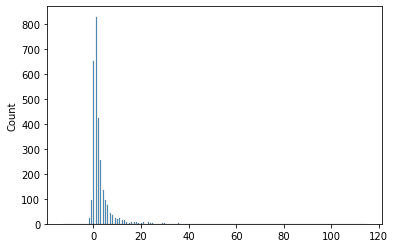

In [126]:
sns.histplot(x.apply(lambda x: x["IONBOT_v0.8.0"] - x["IONBOT_v0.6.2"], axis=1))

In [108]:
x.loc[:,"NSAF_IONBOT_v0.8.0 NSAF_IONBOT_v0.6.2".split()].dropna()

,NSAF_IONBOT_v0.8.0,NSAF_IONBOT_v0.6.2
0,0.000761,0.000000
1,0.000148,0.000000
2,0.000083,0.000329
3,0.000060,0.000000
4,0.000139,0.000548
...,...,...
2858,0.000053,0.000000
2859,0.000061,0.000000
2860,0.000109,0.000000
2861,0.000088,0.000347


In [45]:
v8.iloc[13407]["proteins"]

'RMXL3_HUMAN((50-64))((Q8N7X1))||RMXL2_HUMAN((50-64))((O75526))||RBMX_HUMAN((50-64))((P38159))||RMXL1_HUMAN((50-64))((Q96E39))'

In [53]:
# A0A087WWA7 is obsolete in uniprot, meaning parser failed for O14640 although it could be detected.
v6.proteins.iloc[9]

'sp|P0DMV9|HS71B_HUMAN((57-72))||sp|P0DMV8|HS71A_HUMAN((57-72))||tr|A0A0G2JIW1|A0A0G2JIW1_HUMAN((58-73))'

In [141]:
sum(x.apply(lambda x: x["IONBOT_v0.8.0"] - x["IONBOT_v0.6.2"], axis=1))

7487

In [140]:
x[["IONBOT_v0.8.0",	"IONBOT_v0.6.2"]].sum()

IONBOT_v0.8.0    11516
IONBOT_v0.6.2     4029
dtype: int64

In [91]:
pearsonr(x.loc[:,"NSAF_IONBOT_v0.8.0 NSAF_IONBOT_v0.6.2".split()].dropna()["NSAF_IONBOT_v0.8.0"],x.loc[:,"NSAF_IONBOT_v0.8.0 NSAF_IONBOT_v0.6.2".split()].dropna()["NSAF_IONBOT_v0.6.2"])

(0.8643238912752779, 0.0)

In [25]:
x=x.replace(0,np.nan)
x

AttributeError: 'dict' object has no attribute 'replace'

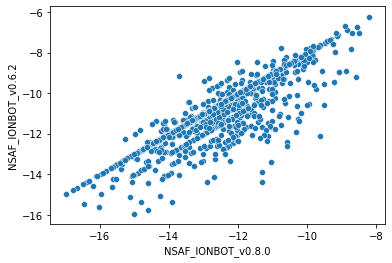

In [31]:
sns.scatterplot(data=np.log2(x.loc[:,"NSAF_IONBOT_v0.8.0 NSAF_IONBOT_v0.6.2".split()]), x="NSAF_IONBOT_v0.8.0", y ="NSAF_IONBOT_v0.6.2")

In [ ]:
len(metrics_comparison)

379

In [2]:
import json

In [28]:
with open("ionbot_version_comparisonx.json", "w") as outfile:
    json_object = json.dumps(metrics_comparison)
    outfile.write(json_object)

In [17]:
metrics_comparison = json_object

In [18]:
correlations = {}
spectra_diff = {}
spectra_diff_perc = {}
for filename_, output_ in metrics_comparison.items():
    for comp_, metrics_ in output_.items():
        if comp_ not in correlations.keys():
            correlations[comp_] = [metrics_[0][0]]
            spectra_diff[comp_] = [metrics_[3]]
            spectra_diff_perc[comp_] = [metrics_[3]/max(metrics_[1], metrics_[2])]
            
        else:
            correlations[comp_].append(metrics_[0][0])
            spectra_diff[comp_].append(metrics_[3])
            spectra_diff_perc[comp_].append(metrics_[3]/max(metrics_[1], metrics_[2]))

In [19]:
correlations.keys()

dict_keys(['IONBOT_v0.8.0-IONBOT_v0.6.2', 'IONBOT_v0.8.0-IONBOT_v0.7.0', 'IONBOT_v0.6.2-IONBOT_v0.7.0', 'IONBOT_v0.7.0-IONBOT_v0.8.0', 'IONBOT_v0.7.0-IONBOT_v0.6.2'])

In [20]:
correlations_v8_v6 = pd.DataFrame(correlations['IONBOT_v0.8.0-IONBOT_v0.6.2'])
correlations_v8_v7 = pd.DataFrame(correlations['IONBOT_v0.8.0-IONBOT_v0.7.0']+ correlations['IONBOT_v0.7.0-IONBOT_v0.8.0'])
correlations_v7_v6 = pd.DataFrame(correlations['IONBOT_v0.7.0-IONBOT_v0.6.2']+ correlations['IONBOT_v0.6.2-IONBOT_v0.7.0'])

correlations_v8_v6["version"] = "V8-V6"
correlations_v8_v7["version"] = "V8-V7"
correlations_v7_v6["version"] = "V7-V6"

In [21]:
spectra_diff_perc_v8_v6 = pd.DataFrame(spectra_diff_perc['IONBOT_v0.8.0-IONBOT_v0.6.2'])
spectra_diff_perc_v8_v7 = pd.DataFrame(spectra_diff_perc['IONBOT_v0.8.0-IONBOT_v0.7.0']+ spectra_diff_perc['IONBOT_v0.7.0-IONBOT_v0.8.0'])
spectra_diff_perc_v7_v6 = pd.DataFrame(spectra_diff_perc['IONBOT_v0.7.0-IONBOT_v0.6.2']+ spectra_diff_perc['IONBOT_v0.6.2-IONBOT_v0.7.0'])

spectra_diff_perc_v8_v6["version"] = "V8-V6"
spectra_diff_perc_v8_v7["version"] = "V8-V7"
spectra_diff_perc_v7_v6["version"] = "V7-V6"

In [22]:
spectra_diff_v8_v6 = pd.DataFrame(spectra_diff['IONBOT_v0.8.0-IONBOT_v0.6.2'])
spectra_diff_v8_v7 = pd.DataFrame(spectra_diff['IONBOT_v0.8.0-IONBOT_v0.7.0']+ spectra_diff['IONBOT_v0.7.0-IONBOT_v0.8.0'])
spectra_diff_v7_v6 = pd.DataFrame(spectra_diff['IONBOT_v0.7.0-IONBOT_v0.6.2']+ spectra_diff['IONBOT_v0.6.2-IONBOT_v0.7.0'])

spectra_diff_v8_v6["version"] = "V8-V6"
spectra_diff_v8_v7["version"] = "V8-V7"
spectra_diff_v7_v6["version"] = "V7-V6"

In [24]:
import seaborn as sns

In [26]:
len(spectra_diff_perc_v7_v6)

263

In [27]:
len(spectra_diff_v8_v6)

295

In [28]:
len(spectra_diff_v8_v7)

347

Text(0.5, 0, 'Pearson correlation')

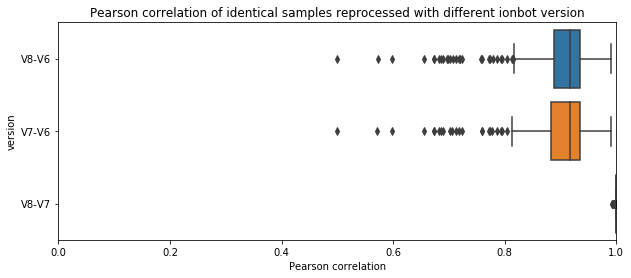

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.xlim((0,1))
sns.boxplot(data=pd.concat([correlations_v8_v6, correlations_v7_v6, correlations_v8_v7],axis=0), x=0,y="version")
plt.title("Pearson correlation of identical samples reprocessed with different ionbot version")
plt.xlabel("Pearson correlation")

In [41]:
correlations_v8_v6[0].min()

0.5001222893523163

In [36]:
print(correlations_v8_v6[0].mean(), correlations_v8_v6[0].std())
print(correlations_v8_v7[0].mean(), correlations_v8_v7[0].std())
print(correlations_v7_v6[0].mean(), correlations_v7_v6[0].std())

0.8963096522365978 0.07007961634472919
0.9996194329369226 0.0008657862737164116
0.896263320916305 0.07027020035454733


Text(0.5, 0, 'Percentage')

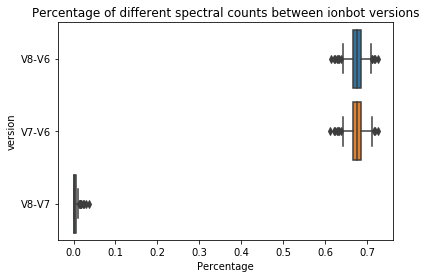

In [38]:
sns.boxplot(data=pd.concat([spectra_diff_perc_v8_v6, spectra_diff_perc_v7_v6, spectra_diff_perc_v8_v7],axis=0), x=0,y="version")
plt.title("Percentage of different spectral counts between ionbot versions")
plt.xlabel("Percentage")

In [37]:
print(spectra_diff_perc_v8_v6[0].mean(), spectra_diff_perc_v8_v6[0].std())
print(spectra_diff_perc_v8_v7[0].mean(), spectra_diff_perc_v8_v7[0].std())
print(spectra_diff_perc_v7_v6[0].mean(), spectra_diff_perc_v7_v6[0].std())

0.6757067541530243 0.015023875105502843
0.0031744488876026353 0.004427544968341615
0.6754839143856367 0.015408925187636329


Text(0.5, 0, 'Number of different spectra')

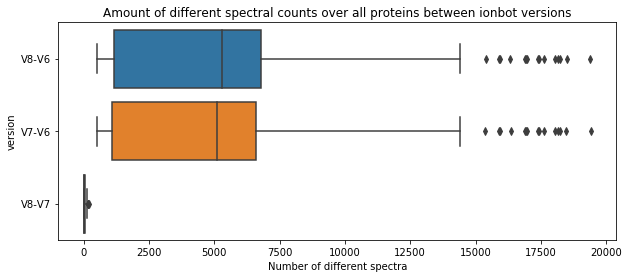

In [35]:
plt.figure(figsize=(10,4))
sns.boxplot(data=pd.concat([spectra_diff_v8_v6, spectra_diff_v7_v6, spectra_diff_v8_v7],axis=0), x=0,y="version")

plt.title("Amount of different spectral counts over all proteins between ionbot versions")
plt.xlabel("Number of different spectra")

In [39]:
print(spectra_diff_v8_v6[0].mean(), spectra_diff_v8_v6[0].std())
print(spectra_diff_v8_v7[0].mean(), spectra_diff_v8_v7[0].std())
print(spectra_diff_v7_v6[0].mean(), spectra_diff_v7_v6[0].std())

5172.562711864407 3777.16292165166
31.377521613832855 37.76905577568322
5067.9087452471485 3955.9309911711002


In [79]:
spectra_diff_v8_v6.min()

0            516
version    V8-V6
dtype: object

In [80]:
spectra_diff_v8_v6.max()

0          19391
version    V8-V6
dtype: object

---